# Customer Segmentation for Auto Finance Marketing

## Domain Knowledge: Applications of Customer Segmentation in Auto Finance

- **Targeted Marketing**: Enables personalized loan and lease campaigns tailored to customer financial behaviors and demographics.
- **Risk Assessment**: Identifies high-risk vs. low-risk customer segments for better credit and loan approval decisions.
- **Product Customization**: Helps design auto financing products (e.g., low-interest loans, leasing) suited to specific customer clusters.
- **Customer Retention**: Supports loyalty programs and re-engagement strategies for inactive or high-value customers.
- **Revenue Optimization**: Maximizes profitability by focusing marketing efforts on high-balance, high-transaction customers.
- **Market Expansion**: Identifies underserved segments (e.g., young or budget-conscious customers) for new financing opportunities.
- **Operational Efficiency**: Streamlines resource allocation by prioritizing high-potential customer segments for outreach.

In [81]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from kneed import KneeLocator

import scipy.cluster.hierarchy as sch

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [82]:
# Load dataset

df = pd.read_csv('bank_transactions.csv')

# Data Preprocessing & EDA : (Data Cleaning)

In [83]:
df.sample(10)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
747356,T747357,C8413560,1/1/1800,M,VIJAYAWADA,35797.71,1/9/16,112640,1741.82
399657,T399658,C4468724,19/3/92,M,GURGAON,10960.23,18/8/16,936,96.00
298962,T298963,C5327639,8/5/89,M,VIZIANAGARAM,3876.49,11/8/16,212841,113.00
740012,T740013,C4039516,29/5/80,F,GURGAON,117266.92,2/9/16,184316,1053.00
188605,T188606,C7934623,9/7/64,M,MUMBAI,17625.87,9/8/16,175515,1425.00
538401,T538402,C6824039,26/8/90,M,UDUMBANCHOLA,7541.65,22/8/16,95324,78.00
960269,T960270,C8911015,23/7/86,M,THANE,98925.54,10/9/16,174047,950.00
7609,T7610,C7866713,4/1/81,F,MUMBAI,101651.34,25/9/16,193851,400.00
447800,T447801,C7532736,1/1/1800,M,VADODARA VADODARA,2.54,16/8/16,180647,116.60
456845,T456846,C2627711,12/1/86,M,MUMBAI,137426.94,21/8/16,142021,330.00


In [84]:
df.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)'],
      dtype='object')

In [85]:
df.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1.046198e+06,1.048567e+06,1.048567e+06
mean,1.154035e+05,1.570875e+05,1.574335e+03
std,8.464854e+05,5.126185e+04,6.574743e+03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.721760e+03,1.240300e+05,1.610000e+02
50%,1.679218e+04,1.642260e+05,4.590300e+02
75%,5.765736e+04,2.000100e+05,1.200000e+03
max,1.150355e+08,2.359590e+05,1.560035e+06


In [86]:
df.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [87]:
df.shape

(1048567, 9)

**Dropping vs. Imputation in This Project**

**Imputation is better** for the Customer Segmentation for Auto Finance Marketing project.

**Why**:
- **Dataset Size**: With over 1M rows, dropping ~0.66% of data (missing values) loses minimal information, but imputation (e.g., mode for `CustGender`, median for `CustAccountBalance`) preserves all customers, ensuring comprehensive segmentation for Financial’s marketing.
- **Bias Risk**: Dropping non-random missing values (e.g., low-income customers’ `CustAccountBalance`) can bias segments, while imputation maintains representativeness.
- **Real Value**: Imputed values (e.g., median age by gender) are realistic approximations, especially for small missing percentages, and align with financial data patterns.

**Dropping**: Dropping avoids introducing artificial data, ensuring only “real” values. However, in this large dataset, imputation’s minor approximations outweigh the loss of valuable customer data, especially for RFM-based segmentation where every customer counts.

**Short Answer**: Imputation is better because it preserves data in a large dataset, minimizes bias, and provides realistic approximations, ensuring robust segmentation for GM Financial’s marketing goals.

In [88]:
df.CustGender.mode()

0    M
Name: CustGender, dtype: object

In [89]:
# CustGender: Impute with mode ('M')
df['CustGender'].fillna(df['CustGender'].mode()[0], inplace=True)

In [90]:
df['CustLocation'].mode()

0    MUMBAI
Name: CustLocation, dtype: object

In [91]:
# CustLocation: Impute with mode ('MUMBAI')
df['CustLocation'].fillna(df['CustLocation'].mode()[0], inplace=True)

In [92]:
df['CustAccountBalance'].median()

16792.18

In [93]:
# CustAccountBalance: Impute with median
df['CustAccountBalance'].fillna(df['CustAccountBalance'].median(), inplace=True)

In [94]:
# Converts CustomerDOB column to datetime format.
# errors='coerce' will convert invalid or missing entries to NaT (Not a Time).
# format='mixed' handles multiple datetime formats.

df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format='mixed', errors='coerce')

In [95]:
df.CustomerDOB.unique()

<DatetimeArray>
['1994-10-01 00:00:00', '2057-04-04 00:00:00', '1996-11-26 00:00:00',
 '2073-09-14 00:00:00', '1988-03-24 00:00:00', '2072-08-10 00:00:00',
 '1992-01-26 00:00:00', '1982-01-27 00:00:00', '1988-04-19 00:00:00',
 '1984-06-22 00:00:00',
 ...
 '2057-10-13 00:00:00', '2044-07-30 00:00:00', '2005-08-15 00:00:00',
 '2046-06-04 00:00:00', '2050-07-01 00:00:00', '2015-11-18 00:00:00',
 '2045-06-28 00:00:00', '2065-07-18 00:00:00', '2042-05-15 00:00:00',
 '2044-10-24 00:00:00']
Length: 17255, dtype: datetime64[ns]

In [96]:
# CustomerDOB: Impute by estimating age based on median age by CustGender

median_age_by_gender = df.groupby('CustGender')['CustomerDOB'].apply(
    lambda x: pd.to_datetime('2025') - pd.Timedelta(days=365.25 * x.dropna().apply(
        lambda dob: 2025 - dob.year).median())
)
median_age_by_gender

CustGender
F   1989-01-01 00:00:00
M   1988-01-01 18:00:00
T   1799-12-30 18:00:00
Name: CustomerDOB, dtype: datetime64[ns]

In [97]:
df['CustomerDOB'] = df.apply(
    lambda row: median_age_by_gender[row['CustGender']] if pd.isna(row['CustomerDOB']) else row['CustomerDOB'], axis=1
)

In [98]:
df.CustomerDOB.isnull().sum()

0

In [99]:
# Convert dates and adjust future dates
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='mixed')
df['CustomerDOB'] = df['CustomerDOB'].apply(lambda x: x - pd.DateOffset(years=100) if x > datetime.now() else x)
df['TransactionDate'] = df['TransactionDate'].apply(lambda x: x - pd.DateOffset(years=100) if x > datetime.now() else x)

In [100]:
# Calculate CustomerAge
df['CustomerAge'] = df['TransactionDate'].dt.year - df['CustomerDOB'].dt.year

In [101]:
df.CustomerAge.describe()

count    1.048567e+06
mean     4.113424e+01
std      4.290906e+01
min     -9.000000e+00
25%      2.500000e+01
50%      2.900000e+01
75%      3.600000e+01
max      2.160000e+02
Name: CustomerAge, dtype: float64

we drop `CustomerAge` < 0 or > 100 for outlier handling.

- **Outlier Detection**: Ages < 0 or > 100 are unrealistic and likely data errors (e.g., incorrect `CustomerDOB`).
- **Data Quality**: Dropping ensures accurate customer profiles for Financial’s segmentation.
- **Impact on Clustering**: Extreme ages skew K-Means clustering, affecting segment reliability.
- **Minimal Data Loss**: 57,384 rows (5.5% of 1M) is small, preserving most data.
- **Alignment with Domain**: Auto finance customers typically fall within 0–100 age range.

In [102]:
df[(df['CustomerAge'] < 0) | (df['CustomerAge'] > 100)].shape

(57384, 10)

In [103]:
df.CustGender.unique()

array(['F', 'M', 'T'], dtype=object)

In [104]:
df[df['CustAccountBalance'] < df['TransactionAmount (INR)']].shape

(103594, 10)

In [105]:
df.shape

(1048567, 10)

In [106]:
# Filter invalid data
df = df[df['CustGender'].isin(['M', 'F'])]
df = df[(df['CustomerAge'] >= 0) & (df['CustomerAge'] <= 100)]
df = df[df['CustAccountBalance'] >= df['TransactionAmount (INR)']]

In [107]:
df.shape

(893946, 10)

In [108]:
df.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
CustomerAge                0
dtype: int64

# Feature Engineering

Here's a **comparison table** between **RFM analysis**, **Correlation**, and **VIF** in the context of **feature engineering**:

| **Aspect**                | **RFM Table**                                                          | **Correlation**                                               | **VIF (Variance Inflation Factor)**                         |
| ------------------------- | ---------------------------------------------------------------------- | ------------------------------------------------------------- | ----------------------------------------------------------- |
| **1. Purpose**            | Customer segmentation based on behavior (Recency, Frequency, Monetary) | Measures strength/direction of relationship between variables | Detects multicollinearity between independent features      |
| **2. Output**             | RFM scores or segments (e.g., 111, 555)                                | Correlation matrix (values between -1 and +1)                 | VIF values (typically >10 indicates high multicollinearity) |
| **3. Data Used**          | Transactional/customer-level data                                      | Any numeric dataset with continuous variables                 | Only independent variables (predictors/features)            |
| **4. Use in Modeling**    | Creates new features for customer behavior                             | Helps in feature selection by removing weakly correlated vars | Helps drop redundant features to improve model stability    |
| **5. Domain Specificity** | Highly domain-specific (mostly used in marketing/CRM)                  | Generic, used across all domains                              | Generic, mostly used in regression modeling                 |

---

### Summary:

* **RFM** is a *feature creation* technique.
* **Correlation** is a *feature selection* tool.
* **VIF** is a *diagnostic tool* for multicollinearity, often used in regression contexts.



five one-liner bullet points explaining **RFM**:

* **RFM** stands for **Recency, Frequency, and Monetary** value analysis.
* It is used to segment customers based on their **purchase behavior**.
* **Recency** measures how recently a customer made a purchase.
* **Frequency** captures how often a customer makes purchases.
* **Monetary** reflects how much money the customer has spent.


In [109]:
# Creating RFM table by grouping by CustomerID
mrf_df = df.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Frequency
    'CustGender': 'first',
    'CustLocation': 'first',
    'CustAccountBalance': 'mean',  # Monetary
    'TransactionAmount (INR)': 'mean',  # Monetary
    'CustomerAge': 'median',
    'TransactionDate': ['min', 'max']
}).reset_index()

In [110]:
mrf_df

CustomerID TransactionID CustGender CustLocation CustAccountBalance  \
                          count      first        first               mean   
0        C1010011             2          F        NOIDA          76340.635   
1        C1010012             1          M       MUMBAI          24204.490   
2        C1010014             2          F       MUMBAI         100112.950   
3        C1010018             1          F    CHAMPARAN            496.180   
4        C1010024             1          M      KOLKATA          87058.650   
...           ...           ...        ...          ...                ...   
772190   C9099836             1          M     BHIWANDI         133067.230   
772191   C9099877             1          M    BANGALORE          96063.460   
772192   C9099919             1          M       GUNTUR           5559.750   
772193   C9099941             1          M      CHENNAI          35295.920   
772194   C9099956             1          M    MUSSOORIE           6968.930   

       TransactionAmount (INR) CustomerAge TransactionDate             
                          mean      median             min        max  
0                       2553.0        28.5      2016-09-08 2016-09-26  
1                       1499.0        22.0      2016-08-14 2016-08-14  
2                        727.5        28.0      2016-01-08 2016-07-08  
3                         30.0        26.0      2016-09-15 2016-09-15  
4                       5000.0        51.0      2016-08-18 2016-08-18  
...                        ...         ...             ...        ...  
772190                   691.0        26.0      2016-07-08 2016-07-08  
772191                   222.0        20.0      2016-09-15 2016-09-15  
772192                   126.0        23.0      2016-08-18 2016-08-18  
772193                    50.0        21.0      2016-08-28 2016-08-28  
772194                   855.0        34.0      2016-09-25 2016-09-25  

[772195 rows x 9 columns]

---

### 🔹 Why use `'first'` for categorical fields?

* **CustomerID** is the grouping key — each group represents one customer.
* `CustGender` and `CustLocation` are **assumed to be fixed per customer** (i.e., gender and location don't change across transactions).
* `'first'` just picks the **first non-null value** for each customer — it's a **quick and efficient way** to carry over those fixed attributes.
* Using `'first'`, `'last'`, or even `'mode'` would give the **same result** if the values are consistent per customer.

---

### ✅ Alternative (if values vary, e.g., due to data quality issues):

If you suspect that `CustGender` or `CustLocation` might vary (due to inconsistent entries), it's safer to use:

* `'mode'`: most frequent value per customer.
* A custom function with consistency check (e.g., raise error if multiple unique values exist).

---


In [111]:
# Rename columns
mrf_df.columns = ['CustomerID', 'Frequency', 'CustGender', 'CustLocation', 
                  'CustAccountBalance', 'TransactionAmount', 'CustomerAge', 
                  'FirstTransaction', 'LastTransaction']

In [112]:
# Fix Recency: Days from LastTransaction to reference date (2016-10-01)
mrf_df['Recency'] = (pd.to_datetime('2016-10-01') - mrf_df['LastTransaction']).dt.days
mrf_df['Recency'] = mrf_df['Recency'].apply(lambda x: max(x, 1))  # Ensure no zeros

In [113]:
# Cap outliers using IQR
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower, upper)
    return df

In [114]:
for col in ['CustAccountBalance', 'TransactionAmount', 'CustomerAge', 'Recency']:
    mrf_df = cap_outliers(mrf_df, col)

In [115]:
# Drop unnecessary columns
mrf_df.drop(['CustomerID', 'FirstTransaction', 'LastTransaction'], axis=1, inplace=True)

In [116]:
mrf_df.sample(5)

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount,CustomerAge,Recency
619678,2,M,DELHI,24096.97,466.5,30.5,5
743595,1,M,GURGAON,153074.03,1110.3,36.0,5
693956,1,M,BANGALORE,7976.96,920.0,30.0,42
463784,1,F,NEW DELHI,5842.92,249.0,32.0,31
608147,1,M,NEW DELHI,28935.74,107.0,28.0,36


# EDA

In [117]:
mrf_df.describe()

,Frequency,CustAccountBalance,TransactionAmount,CustomerAge,Recency
count,772195.000000,772195.000000,772195.000000,772195.000000,772195.000000
mean,1.157669,45927.841391,773.073855,30.661052,61.367210
std,0.412269,51866.453086,798.418990,6.971780,61.523546
min,1.000000,0.000000,0.000000,12.750000,1.000000
25%,1.000000,7904.030000,173.000000,25.500000,17.000000
50%,1.000000,21449.230000,450.000000,29.000000,40.000000
75%,1.000000,65972.030000,1104.000000,34.000000,85.000000
max,6.000000,153074.030000,2500.500000,46.750000,187.000000


In [118]:
mrf_df.Recency.unique()

array([  5,  48,  85,  16,  44,  33, 176,  35,  36,  23,  84, 187,   1,
        34, 115,  53,  47, 145,  18,  17,  43,  45,  13, 114,  22,  46,
        49,   6,   4,  37, 146,   9,   8,  41, 175,  39,  31,  38,  40,
        32,  42,  54], dtype=int64)

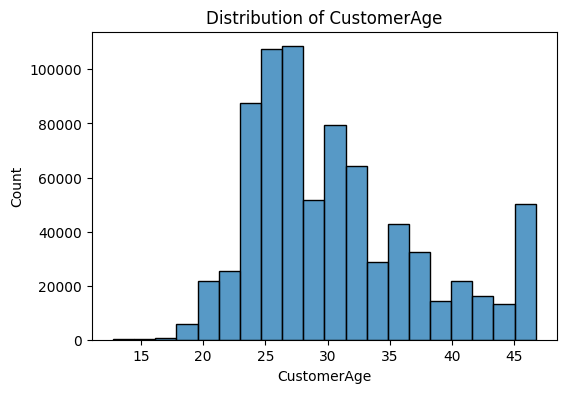

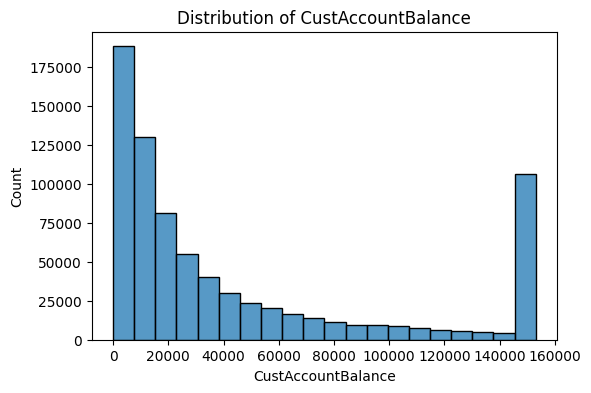

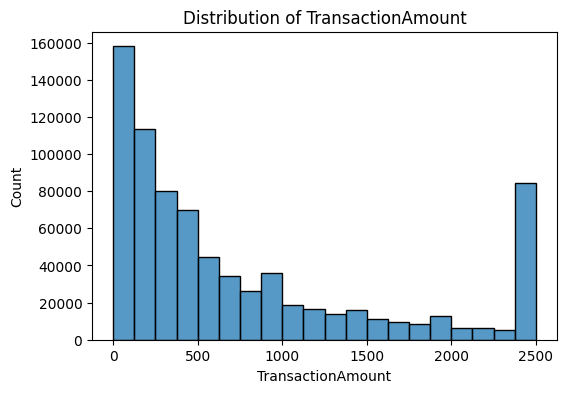

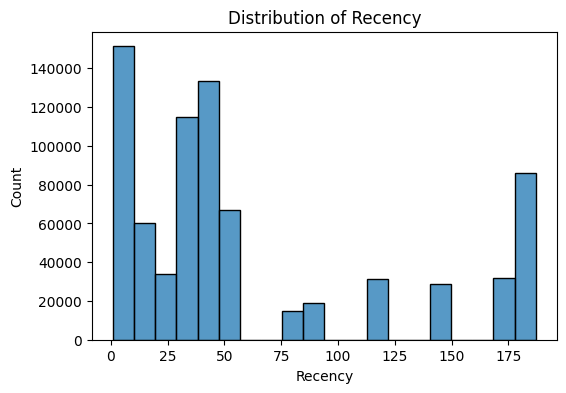

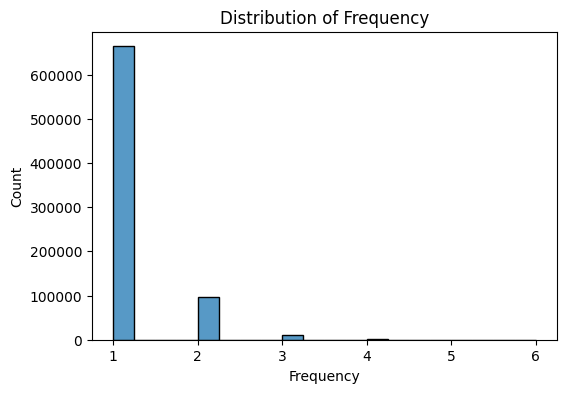

In [119]:
# Distributions
for col in ['CustomerAge', 'CustAccountBalance', 'TransactionAmount', 'Recency', 'Frequency']:
    plt.figure(figsize=(6, 4))
    sns.histplot(mrf_df[col], bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()

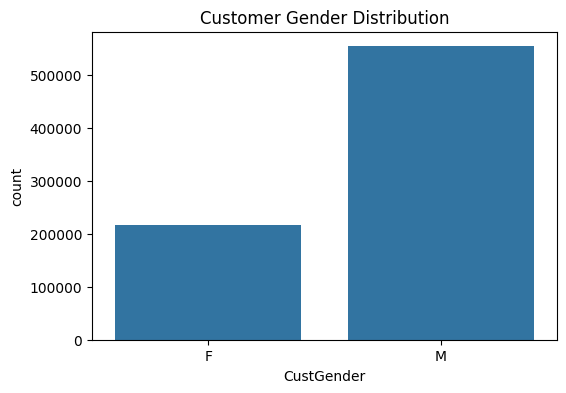

In [120]:
# Gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=mrf_df, x='CustGender')
plt.title('Customer Gender Distribution')
plt.show()

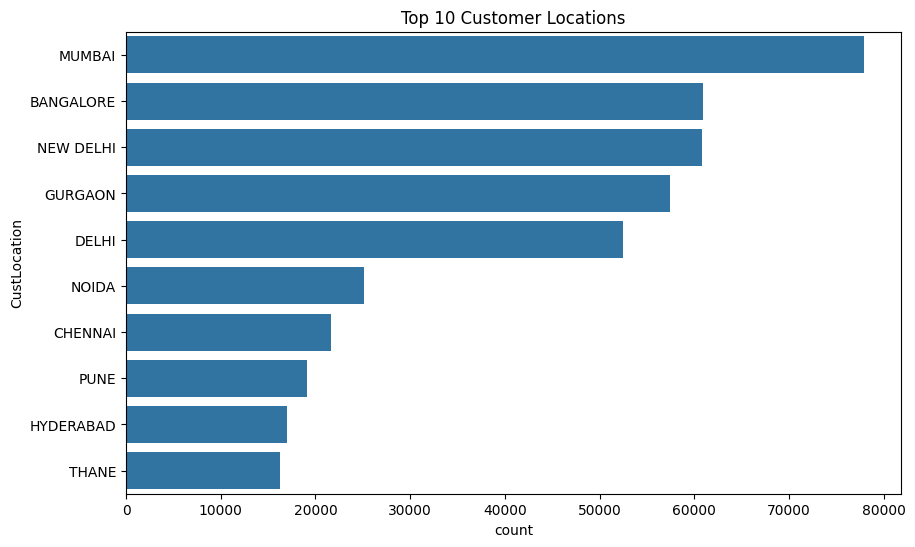

In [41]:
# Top 10 locations
plt.figure(figsize=(10, 6))
sns.countplot(y='CustLocation', data=mrf_df, order=mrf_df['CustLocation'].value_counts().index[:10])
plt.title('Top 10 Customer Locations')
plt.show()

# Data Preparation

In [121]:
# Encode categorical variables
mrf_df['CustGender'] = mrf_df['CustGender'].map({'M': 1, 'F': 0})

In [122]:
# Select features for clustering
features = ['Frequency', 'CustGender', 'CustAccountBalance', 'TransactionAmount', 'CustomerAge', 'Recency']
mrf_scaled = mrf_df[features]

In [123]:
# Scale features
scaler = StandardScaler()
mrf_scaled = scaler.fit_transform(mrf_scaled)
mrf_scaled = pd.DataFrame(mrf_scaled, columns=features)

In [124]:
mrf_scaled.sample(5)

,Frequency,CustGender,CustAccountBalance,TransactionAmount,CustomerAge,Recency
122830,-0.382441,-1.596421,2.065810,2.163560,2.307726,-0.298540
493428,-0.382441,0.626401,1.598680,2.163560,0.478924,-0.737396
691931,-0.382441,0.626401,-0.521561,2.037686,2.307726,0.384126
343683,-0.382441,-1.596421,-0.503698,-0.360806,-0.525125,-0.981206
194645,-0.382441,-1.596421,-0.129084,0.472091,-0.238254,-0.396063


In [125]:
# Stratified sampling by CustGender (10% of data)
mrf_sampled = mrf_scaled.groupby('CustGender').apply(
    lambda x: x.sample(frac=0.2, random_state=42)
).reset_index(drop=True)
print("Sampled Dataset Shape:", mrf_sampled.shape)

Sampled Dataset Shape: (154439, 6)


# Clustering with K-Means

In [130]:
# Determining optimal number of clusters using elbow method
inertias = []
k_range = range(2, 9)  # Reduced range for speed

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=5, max_iter=300, random_state=42)
    kmeans.fit(mrf_sampled)
    inertias.append(kmeans.inertia_)

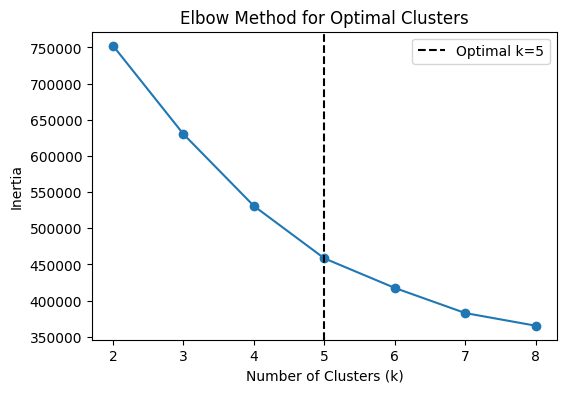

Optimal number of clusters: 5


In [131]:
# Plot elbow curve
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
kl = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')
plt.axvline(x=kl.elbow, color='black', linestyle='--', label=f'Optimal k={kl.elbow}')
plt.legend()
plt.show()

# Print optimal k
print(f"Optimal number of clusters: {kl.elbow}")

In [132]:
# Fit K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=5, max_iter=300, random_state=42)
mrf_df['Cluster2'] = kmeans.fit_predict(mrf_scaled)

# Summarize clusters
for cluster in range(5):
    print(f'\nCluster {cluster}:')
    cluster_data = mrf_df[mrf_df['Cluster2'] == cluster]
    print(f'Mean Account Balance: {cluster_data["CustAccountBalance"].mean():.2f}')
    print(f'Mean Transaction Amount: {cluster_data["TransactionAmount"].mean():.2f}')
    print(f'Mean Customer Age: {cluster_data["CustomerAge"].mean():.2f}')
    print(f'Mean Recency: {cluster_data["Recency"].mean():.2f}')
    print(f'Most Frequent Gender: {"Male" if cluster_data["CustGender"].mode()[0] == 1 else "Female"}')


Cluster 0:
Mean Account Balance: 21732.25
Mean Transaction Amount: 443.75
Mean Customer Age: 28.89
Mean Recency: 31.21
Most Frequent Gender: Male

Cluster 1:
Mean Account Balance: 114359.80
Mean Transaction Amount: 1615.72
Mean Customer Age: 37.50
Mean Recency: 53.54
Most Frequent Gender: Male

Cluster 2:
Mean Account Balance: 30066.88
Mean Transaction Amount: 614.91
Mean Customer Age: 29.43
Mean Recency: 171.12
Most Frequent Gender: Male

Cluster 3:
Mean Account Balance: 35275.15
Mean Transaction Amount: 681.28
Mean Customer Age: 28.51
Mean Recency: 41.10
Most Frequent Gender: Female

Cluster 4:
Mean Account Balance: 52455.20
Mean Transaction Amount: 834.52
Mean Customer Age: 30.56
Mean Recency: 28.72
Most Frequent Gender: Male


In [133]:
mrf_df.sample(5)

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount,CustomerAge,Recency,Cluster2
383033,2,0,GUWAHATI,15215.35,610.00,31.0,54,4
314025,1,1,MUMBAI,153074.03,238.00,29.0,40,1
183717,1,1,KARAULI,2486.30,268.29,22.0,85,0
44271,1,1,SINGHWARA,32300.24,263.00,24.0,84,0
364327,1,1,LUCKNOW,54197.01,520.00,28.0,187,2


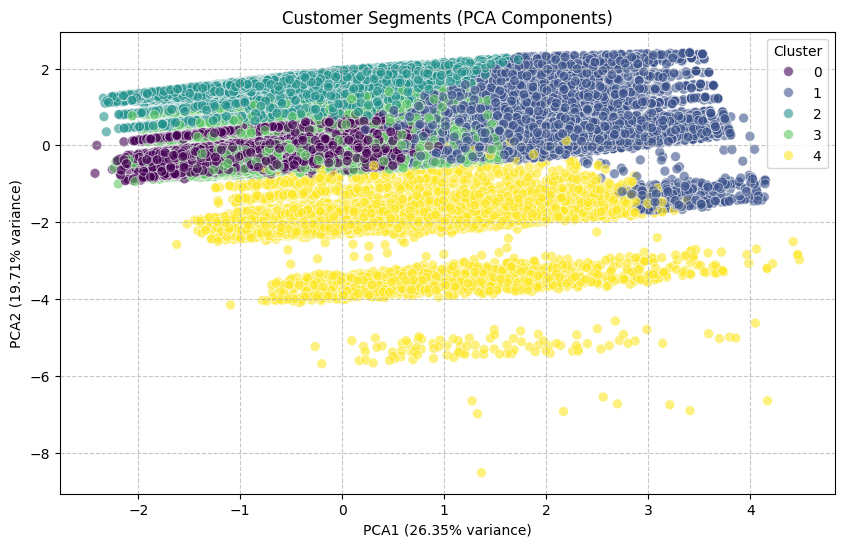

In [135]:
fig = plt.figure(figsize=(10, 6))
sns.scatterplot(data=mrf_sampled, x='PCA1', y='PCA2', hue='Cluster2', palette='viridis', alpha=0.6, s=50)
plt.title('Customer Segments (PCA Components)')
plt.xlabel(f'PCA1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PCA2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Cluster')
plt.show()


### Explaining the Clusters
The clusters are derived from K-Means with 5 clusters on scaled features. Below is a detailed explanation tailored for Financial’s auto finance marketing, with actionable insights for stakeholders.

#### Cluster Summaries 
- **Cluster 0**:
  - **Profile**: Young males (mean age 28.89 years), low account balances (21,732.25 INR), low transaction amounts (443.75 INR), recent transactions (mean recency 31.21 days).
  - **Marketing Strategy**: Target with starter loans or lease promotions for compact vehicles, appealing to young, budget-conscious males starting their financial journey.
  - **PCA Plot**: Likely in a region with lower PCA1/PCA2 values, reflecting low financial metrics and recent activity.

- **Cluster 1**:
  - **Profile**: Older males (37.50 years), high account balances (114,359.80 INR), high transaction amounts (1,615.72 INR), moderately recent transactions (53.54 days).
  - **Marketing Strategy**: Offer premium loans or financing for luxury vehicles (e.g., Cadillac), targeting affluent, middle-aged customers.
  - **PCA Plot**: Positioned in the highest PCA1/PCA2 region, driven by high financial metrics.

- **Cluster 2**:
  - **Profile**: Young males (29.43 years), moderate account balances (30,066.88 INR), moderate transaction amounts (614.91 INR), least recent transactions (171.12 days).
  - **Marketing Strategy**: Re-engage with promotional financing or loyalty programs to reactivate these less active customers for mid-tier vehicles.
  - **PCA Plot**: Likely lower on PCA2, reflecting high recency (less recent transactions).

- **Cluster 3**:
  - **Profile**: Young females (28.51 years), moderate account balances (35,275.15 INR), moderate transaction amounts (681.28 INR), recent transactions (41.10 days).
  - **Marketing Strategy**: Target with entry-level auto loans or compact vehicle promotions, appealing to young, financially stable women.
  - **PCA Plot**: Centrally located, reflecting moderate metrics and female gender (`CustGender=0`).

- **Cluster 4**:
  - **Profile**: Middle-aged males (30.56 years), moderate-high account balances (52,455.20 INR), moderate transaction amounts (834.52 INR), very recent transactions (28.72 days).
  - **Marketing Strategy**: Promote mid-tier financing or crossover/SUV loans for active, mid-career customers.
  - **PCA Plot**: Central-high PCA1/PCA2, reflecting moderate financials and recent activity.

#### Visualization Interpretation
The PCA scatter plot shows the distribution of customers across these 5 clusters in a 2D space:
- **PCA1/PCA2 Axes**: Represent linear combinations of the 6 features, with `PCA1` likely capturing financial metrics (`CustAccountBalance`, `TransactionAmount`) and `PCA2` influenced by `Recency`, `CustomerAge`, or `CustGender`. The explained variance ratios (e.g., ~30–40% each, typical for PCA) indicate how much information is retained.
- **Cluster Separation**: Distinct color groups (via `viridis`) show cluster boundaries. Cluster 1 (high balances) likely forms a distinct high-PCA1 region, Cluster 2 (high recency) a low-PCA2 region, and others cluster centrally.
- **Stakeholder Insight**: The plot visually confirms segmentation, with summaries providing actionable profiles for targeting loan/lease campaigns.







# SQL data extraction

Below is a table comparing **general optimization techniques** and **resources** for Pandas and SQL, focusing on five key differences in their approaches to data processing, independent of the **Customer Segmentation for Auto Finance Marketing** project. The table addresses performance optimization, resource usage, and scalability, keeping in mind general data analysis needs and your concern about laptop performance.

| **Aspect**                | **Pandas Optimization**                                                                 | **SQL Optimization**                                                                    |
|---------------------------|---------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| **Data Processing**       | Uses vectorized operations via NumPy for fast in-memory computations (e.g., filtering, aggregations). Optimize by chunking large datasets (`pd.read_csv(chunksize=100000)`) to process in smaller batches. | Leverages database query optimizers and indexes (e.g., `CREATE INDEX ON table(column)`) to speed up queries like `SELECT`, `JOIN`, and `GROUP BY` on large datasets. |
| **Memory Management**     | Loads data into RAM, which can strain memory on large datasets. Optimize by using efficient dtypes (e.g., `float32` instead of `float64`, `category` for strings) to reduce memory usage. | Processes data on the database server, minimizing client-side memory usage. Optimize by partitioning tables (e.g., by date or key ranges) to manage large datasets efficiently. |
| **Parallelization**       | Single-threaded by default, leading to slower processing for large data. Optimize with libraries like `dask` or `modin` to enable parallel processing across multi-core CPUs or clusters. | Database engines (e.g., PostgreSQL, SQL Server) often support parallel query execution. Optimize by configuring server settings (e.g., `max_parallel_workers` in PostgreSQL) for multi-core utilization. |
| **Query Performance**     | Relies on in-memory indexing, which is slower for large datasets without optimization. Use `set_index` for frequent lookups or `numba` for custom computations to boost speed. | Uses B-tree or hash indexes for fast lookups and joins. Optimize by creating covering indexes (e.g., `CREATE INDEX ON table(column1, column2)`) to reduce disk I/O for common queries. |
| **Scalability**           | Limited by local machine RAM and CPU (e.g., laptop with 16GB RAM struggles with >10M rows). Optimize by offloading to distributed systems like `dask` or using `vaex` for out-of-core processing. | Scales with database server resources (e.g., cloud databases like AWS RDS). Optimize by sharding (splitting data across servers) or clustering for distributed query execution on massive datasets. |

### Notes
- **Pandas Resources**: Runs locally on your machine (e.g., laptop), using local CPU and RAM. Performance depends on hardware (e.g., 8GB RAM may limit large datasets). External libraries like `dask` or `modin` require installation (`pip install dask modin`).
- **SQL Resources**: Runs on a database server (local or cloud, e.g., MySQL, PostgreSQL), leveraging server CPU, RAM, and disk. Requires DBMS setup and network access for remote servers.
- **Local vs. Server**: Pandas works locally (no server needed unless using distributed tools), while SQL typically runs on a database server (local or remote), though SQLite can run locally for small datasets.
- **Optimization Focus**: Pandas optimizations target memory and CPU efficiency on a single machine, while SQL optimizations focus on query planning and server resource management for scalability.


### Table: SAS in the Data Science Project Pipeline

| **Pipeline Phase**         | **SAS Capability**                                                                 | **Is SAS Useful?** | **Language Integration** | **Optimization Strategies**                              | **Limitations**                                      |
|----------------------------|-----------------------------------------------------------------------------------|--------------------|--------------------------|---------------------------------------------------------|-----------------------------------------------------|
| **Data Extraction**        | Strong (`PROC SQL`, `LIBNAME`, `PROC IMPORT`) for databases, CSVs, enterprise systems | Yes                | SQL, Python (`saspy`)   | Use `WHERE` clauses, indexes, `COMPRESS=YES`           | Weak for unstructured data (e.g., web scraping)      |
| **Data Preprocessing**     | Robust (`DATA` steps, `PROC SQL`) for transformations, encoding                   | Yes                | SQL, Python (`saspy`)   | Single `DATA` step, `KEEP`/`DROP` options              | Less flexible than Pandas for complex transformations |
| **Data Cleaning**          | Effective (`DATA` steps, `PROC UNIVARIATE`) for outliers, error correction        | Yes                | SQL, Python (`saspy`)   | Use `PROC MEANS`, single-step cleaning                 | Less intuitive than Pandas for ad-hoc cleaning      |
| **Feature Engineering**    | Strong (`DATA` steps, `PROC STDIZE`) for feature creation, scaling                | Yes                | SQL, Python (`saspy`)   | Use `PROC TRANSPOSE`, minimize data passes             | Limited for complex features (e.g., NLP)            |
| **Model Building**         | Robust (`PROC FASTCLUS`, `PROC LOGISTIC`, `PROC HPFOREST`) for ML/statistics      | Yes                | Python (`scikit-learn`) | High-performance procedures (e.g., `PROC HPCLUS`)      | Less flexible than Python for cutting-edge ML       |
| **Visualization**          | Good (`PROC SGPLOT`, SAS Visual Analytics) for static/interactive plots          | Yes                | Python (Matplotlib)     | `ODS GRAPHICS`, SAS Visual Analytics for dashboards    | Tableau/Python more flexible for custom dashboards  |
| **Optimization**           | Strong (indexing, compression, SAS Grid) for large-scale processing               | Yes                | SQL, Python (`saspy`)   | Multi-threading (`MP CONNECT`), in-database processing | Python’s `dask` simpler for local optimization      |
| **Hyperparameter Tuning**  | Supported (`PROC HPGRID`, macros) for model optimization                          | Moderate           | Python (`GridSearchCV`) | `PROC HPGRID` for automation, macros for custom tuning | Python’s tuning tools are more user-friendly        |
| **Tableau Visualization**  | Limited to data prep (`PROC EXPORT`, connectors) for Tableau integration          | Moderate           | SQL, Python (`saspy`)   | Export aggregated data to reduce Tableau load          | Tableau is primary visualization tool               |
| **Deployment**             | Effective (SAS Viya) for batch scoring, cloud APIs (e.g., AWS)                    | Moderate           | SQL, Python (`SWAT`)    | In-database scoring, cloud deployment (SAS Viya)       | Python’s Flask/FastAPI simpler for custom APIs      |

